<a href="https://colab.research.google.com/github/bigblesslee/kagglewithrhadoop/blob/branch1/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98_%ED%8A%B8%EB%A0%88%EC%9D%B4%EB%94%A9_%EC%8B%9C%EC%8A%A4%ED%85%9C_%EA%B0%9C%EB%B0%9C_%EC%9D%B4%EB%8C%80%EB%B3%B5_CH_5_6~5_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 기본 모듈 임포트
import os
import sys
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 모델링 관련 임포트
import statsmodels.tsa.stattools as ts
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix

## 필요데이터 준비하기


In [109]:
# finance-datareader 설치
pip install -U finance-datareader

Requirement already up-to-date: finance-datareader in /usr/local/lib/python3.6/dist-packages (0.8.0)


In [0]:
import FinanceDataReader as fdr

In [0]:
stk_df = fdr.StockListing('KRX')

In [112]:
stk_df.head()

,Symbol,Name,Sector,Industry
0,155660,DSR,1차 비철금속 제조업,합섬섬유로프
1,001250,GS글로벌,상품 종합 도매업,"수출입업(시멘트,철강금속,전기전자,섬유,기계화학),상품중개,광업,채석업/하수처리 서..."
2,082740,HSD엔진,일반 목적용 기계 제조업,"대형선박용엔진,내연발전엔진"
3,001390,KG케미칼,기초 화학물질 제조업,"콘크리트혼화제, 비료, 친환경농자재, 수처리제"
4,011070,LG이노텍,전자부품 제조업,기타 전자부품 제조업


In [0]:
stk_tickers = stk_df['Symbol']

In [114]:
def get_prc_db(ticker, strt_dt = '2018'):
  tmp_df = fdr.DataReader(ticker, '2018')
  tmp_df['ITM_NO'] = ticker
  return tmp_df

prc_df = pd.DataFrame()
for ticker_nm in stk_tickers[:20]:
  try:
    prc_df = prc_df.append(get_prc_db(ticker_nm))
    print(ticker_nm + '_불러오기_완료')
  except:
    print(ticker_nm + '_불러오기_실패')

155660_불러오기_완료
001250_불러오기_완료
082740_불러오기_완료
001390_불러오기_완료
011070_불러오기_완료
010060_불러오기_완료
001740_불러오기_완료
096770_불러오기_완료
011810_불러오기_완료
024070_불러오기_완료
011420_불러오기_완료
267290_불러오기_완료
012320_불러오기_완료
010130_불러오기_완료
002240_불러오기_완료
014530_불러오기_완료
013700_불러오기_완료
003920_불러오기_완료
090350_불러오기_완료
014160_불러오기_완료


In [115]:
prc_df.head()

,Open,High,Low,Close,Volume,Change,ITM_NO
Date,,,,,,,
2018-01-02,5220,5260,5140,5240,43276,0.013540,155660
2018-01-03,5270,5380,5220,5350,105827,0.020992,155660
2018-01-04,5400,5500,5290,5360,133343,0.001869,155660
2018-01-05,5380,5690,5330,5490,263076,0.024254,155660
2018-01-08,5610,5740,5600,5630,309361,0.025501,155660


### 평균회귀 테스트 (ADF 테스트 계속)

In [116]:
import statsmodels.tsa.stattools as ts

adf_result = ts.adfuller(prc_df[prc_df['ITM_NO']== stk_tickers[0]]['Close'])
print(adf_result)

(-2.1335714429658537, 0.2312313200668526, 1, 418, {'1%': -3.4460914174990296, '5%': -2.868479374038333, '10%': -2.570466459559076}, 5255.337661782507)




---



> * 첫 번째 : 검정 통계량(Test Statistic)
* 두 번째 : p-value
* 네번째 : 데이터 수
* 다섯번째 : 가설검정을 위한 1%, 5%, 10% 기각 값(Critical Value)
  * r=0이라는 가설검정을 기각하려면 검정 통계량 값이 1%, 5%, 10% 기각값 중 어느 하나보다도 작아야 함.
  

---


  
* 삼성전자 주가의 검정 통계량은 -2.62로 기각값 10%인 -2.57보다 크기 때문에 유의수준 10%에서 귀무가설을 기각할 수 있음
  * 즉, 삼성전자에 평균회귀 모형을 적용해 볼 수 있음



---



In [117]:
pv_lst = []
for ticker in stk_tickers[:20]:
  adf_result = ts.adfuller(prc_df[prc_df['ITM_NO']== ticker]['Close'])
  pv_lst.append(adf_result[1])
pv_lst 

[0.2312313200668526,
 0.48811609234573944,
 0.2675332586297395,
 0.8447532182170869,
 0.353325766085713,
 0.5457830712839632,
 0.10015584134728656,
 0.24307839424538685,
 0.7835230797782198,
 0.39110942272616295,
 0.19993158678818052,
 0.8777613601790354,
 0.07464007457259954,
 0.16145978526260396,
 0.3876701238383937,
 0.09144829047227687,
 0.06307653858062057,
 0.8950964580176435,
 0.37732846416453386,
 0.38618166237493773]

### 허스트 지수



---




> * 허스트 지수의 핵심 아이디어는 분산을 확산 속도로 치환할 수 있고, 그 값을 GBM의 확산 속도와 비교하면, 랜덤워크인지 아니면 정상과정인지를 파악할 수 있다는 것임
* 허스트 지수는 정상과정이 평균회귀나 추세 성향이 있는지를 알 수 있을 뿐만 아니라 경향의 정도도 알 수 있어 매우 유용한 지수임
* 예를 들어, H값이 0에 가까울수록 평균회귀 성향이 강하고, 반대로 1에 가까울소록 추세 성향이 강하다고 판단할 수 있음






In [0]:
def get_hurst_exponent(df):
  lags = range(2, 100)
  ts = np.log(df)

  tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
  poly = np.polyfit(np.log(lags), np.log(tau), 1)

  result = poly[0] * 2.0

  return result

In [119]:
hurst_lst = []
for ticker in stk_tickers[:20]:
  hurst_lst.append(get_hurst_exponent(prc_df[prc_df['ITM_NO']== ticker]['Close']))
hurst_lst 

[0.3824179295832717,
 0.31682868118001545,
 0.4929600846983241,
 0.4337518061652332,
 0.49441721888141327,
 0.33445816070171897,
 0.5115917858646453,
 0.23568890949222018,
 0.5001027398269537,
 0.3416834181905906,
 0.38223924266461146,
 0.46224218081606633,
 0.4006126992847144,
 0.4468953802690287,
 0.4243533929380504,
 0.32261778640887734,
 0.45013412270888314,
 0.28942010190711315,
 0.4481814493031878,
 0.3945511190168445]

### 평균회귀의 Half-life



* 주가 데이터 대부분이 평균회귀 모형 적용 가능 테스트에서 실패함
* 상기 2가지 테스트 통과에 실패했더라도, 평균 회귀 모델을 적용할 수 있는지를 알 수 있는 Half-life 값을 소개함
* Half-life는 값이 평균으로 회귀하는 데 걸리는 시간을 의미하는 것으로, 이 값을 이용해 평균회귀 모델을 적용할 수 있는 주가를 찾을 수 있음



---




> * Half-life의 값이 크고 작음은 알고리즘 트레이딩에 적용하는 전략에 따라 좋을 수도 나쁠 수도 있음
* Half-life의 값이 크다는 것은 장기간 지속하는 경향이 있다는 것을 의미할 수 도 있고, 반대로 작다는 것은 그만큼 주식값의 변동이 잦다는 것으로 해석할 수도 있기 때문에 전략에 맞춰 판단해야 함



---









In [0]:
def get_half_life(df):
    price = pd.Series(df)
    lagged_price = price.shift(1).fillna(method='bfill')
    delta = price - lagged_price
    beta = np.polyfit(lagged_price, delta, 1)[0]
    half_life = (-1 * np.log(2) / beta)
    
    return half_life  

In [121]:
half_life_lst = []
for ticker in stk_tickers[:20]:
  half_life_lst.append(get_half_life(prc_df[prc_df['ITM_NO']== ticker]['Close']))
half_life_lst

[27.88958646448812,
 54.76119019918814,
 35.25469805709054,
 152.42725630514113,
 46.233850568015576,
 106.32987878871525,
 33.11236739481462,
 32.21552221342613,
 217.51373770379624,
 88.16417784215004,
 24.997817936902674,
 215.84326400932514,
 44.21641152326024,
 31.539236948723065,
 49.85036825540656,
 10.569900354538612,
 16.95316713180104,
 135.08760207406414,
 64.88345273495081,
 48.93314918900451]

In [122]:
scor_df = pd.DataFrame(data = {'adf':pv_lst,'hurst':hurst_lst,'half_life':half_life_lst}, index=stk_df['Name'][:20])
scor_df

,adf,hurst,half_life
Name,,,
DSR,0.231231,0.382418,27.889586
GS글로벌,0.488116,0.316829,54.761190
HSD엔진,0.267533,0.492960,35.254698
KG케미칼,0.844753,0.433752,152.427256
LG이노텍,0.353326,0.494417,46.233851
OCI,0.545783,0.334458,106.329879
SK네트웍스,0.100156,0.511592,33.112367
SK이노베이션,0.243078,0.235689,32.215522
STX,0.783523,0.500103,217.513738


In [123]:
scor_df.rank()

,adf,hurst,half_life
Name,,,
DSR,7.0,8.0,4.0
GS글로벌,15.0,3.0,13.0
HSD엔진,9.0,17.0,8.0
KG케미칼,18.0,12.0,18.0
LG이노텍,10.0,18.0,10.0
OCI,16.0,5.0,16.0
SK네트웍스,4.0,20.0,7.0
SK이노베이션,8.0,1.0,6.0
STX,17.0,19.0,20.0


In [124]:
scor_df.rank()[scor_df.rank()<10].dropna()

,adf,hurst,half_life
Name,,,
DSR,7.0,8.0,4.0
SK이노베이션,8.0,1.0,6.0
갤럭시아에스엠,6.0,7.0,3.0
극동유화,3.0,4.0,1.0


In [125]:
scor_df.rank()[scor_df.rank()<10].dropna().index

Index(['DSR', 'SK이노베이션', '갤럭시아에스엠', '극동유화'], dtype='object', name='Name')

In [0]:
def get_sig(df):
  df.loc[:,'MA10'] = df['Close'].rolling(10).mean()
  df.loc[:,'ROLLING_STD10'] = df['Close'].rolling(10).std()

  df.loc[:,'DIFF'] = df.loc[:,'Close'] - df.loc[:,'MA10']

  # signal 
  df.loc[:, 'SIG'] = 0
  df.loc[df['DIFF'] > 0, 'SIG'] = -1
  df.loc[df['DIFF'] < 0, 'SIG'] = 1
  
  return df

In [127]:
sig_df = get_sig(prc_df[prc_df['ITM_NO']== stk_tickers[0]])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [128]:
sig_df['y'] = sig_df['Change'].shift(-1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [129]:
sig_df[10:20]

,Open,High,Low,Close,Volume,Change,ITM_NO,MA10,ROLLING_STD10,DIFF,SIG,y
Date,,,,,,,,,,,,
2018-01-16,5390,5480,5380,5450,90476,0.005535,155660,5498.0,106.957936,-48.0,1,-0.005505
2018-01-17,5440,5480,5340,5420,69579,-0.005505,155660,5505.0,98.121240,-85.0,1,0.014760
2018-01-18,5410,5540,5390,5500,109002,0.014760,155660,5519.0,84.122926,-19.0,1,-0.005455
2018-01-19,5500,5560,5440,5470,79755,-0.005455,155660,5517.0,85.120829,-47.0,1,-0.005484
2018-01-22,5450,5490,5360,5440,38198,-0.005484,155660,5498.0,78.002849,-58.0,1,0.009191
2018-01-23,5450,5520,5420,5490,63365,0.009191,155660,5486.0,67.363030,4.0,-1,0.005464
2018-01-24,5490,5600,5470,5520,83615,0.005464,155660,5473.0,38.600518,47.0,-1,0.043478
2018-01-25,5500,5760,5500,5760,261223,0.043478,155660,5499.0,99.045444,261.0,-1,0.012153
2018-01-26,5990,6000,5820,5830,637150,0.012153,155660,5530.0,144.452991,300.0,-1,0.008576


In [130]:
sig_df.loc[sig_df['SIG']==-1,'y'] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


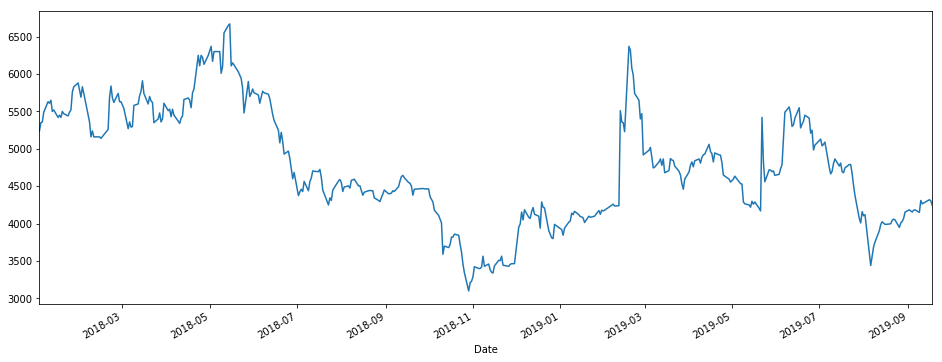

In [131]:
sig_df['Close'].plot(figsize=(16,6))

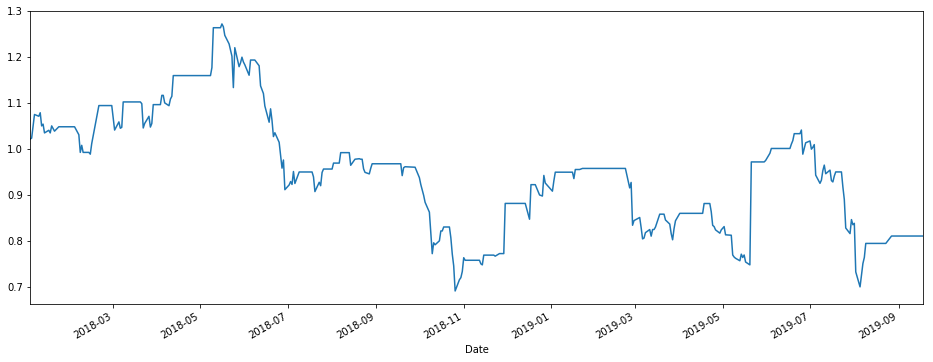

In [0]:
(sig_df['y'] + 1).cumprod().plot(figsize=(16,6))

In [0]:
def get_prod(df):
  sig_df = get_sig(df)
  sig_df['y'] = sig_df['Change'].shift(-1)
  return (sig_df[sig_df['SIG']==1]['y'] + 1).prod()

In [133]:
prod_lst = []
for ticker in stk_tickers[:20]:
  prod_lst.append(get_prod(prc_df[prc_df['ITM_NO']== ticker]))
prod_lst 

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://

[0.7888565904239172,
 0.7500900069607104,
 1.3774736568273684,
 0.8459337506436083,
 0.7234975999722342,
 0.7587693322859899,
 0.9347129245765508,
 1.2366639384528717,
 0.35284329793211344,
 0.8017933943790017,
 0.8562933209778356,
 0.5693138382670134,
 0.6194707925617111,
 0.9114842271318564,
 0.8655262481058127,
 0.9941557605182642,
 1.6199821123019364,
 1.0064678053703409,
 0.6678135973601846,
 1.531993016047163]

In [0]:
scor_df['prod'] = prod_lst

In [135]:
scor_df

,adf,hurst,half_life,prod
Name,,,,
DSR,0.231231,0.382418,27.889586,0.788857
GS글로벌,0.488116,0.316829,54.761190,0.750090
HSD엔진,0.267533,0.492960,35.254698,1.377474
KG케미칼,0.844753,0.433752,152.427256,0.845934
LG이노텍,0.353326,0.494417,46.233851,0.723498
OCI,0.545783,0.334458,106.329879,0.758769
SK네트웍스,0.100156,0.511592,33.112367,0.934713
SK이노베이션,0.243078,0.235689,32.215522,1.236664
STX,0.783523,0.500103,217.513738,0.352843


In [136]:
scor_df['prod'].mean()

0.9106567605548241

In [0]:
scor_df.iloc[:,:-1].rank()[scor_df.iloc[:,:-1].rank()<10].dropna().index

Index(['DSR', 'SK이노베이션', '갤럭시아에스엠', '극동유화'], dtype='object', name='Name')

In [137]:
scor_df.loc[scor_df.iloc[:,:-1].rank()[scor_df.iloc[:,:-1].rank()<10].dropna().index]

,adf,hurst,half_life,prod
Name,,,,
DSR,0.231231,0.382418,27.889586,0.788857
SK이노베이션,0.243078,0.235689,32.215522,1.236664
갤럭시아에스엠,0.199932,0.382239,24.997818,0.856293
극동유화,0.091448,0.322618,10.569900,0.994156


In [138]:
scor_df.loc[scor_df.iloc[:,:-1].rank()[scor_df.iloc[:,:-1].rank()<10].dropna().index]['prod'].mean()

0.9689924025932221

## 머신러닝 모델 구현하기



*   Scikit-learn 라이브러리를 이용해 주가방향을 예측할 수 있는 간단한 주가방향 예측모형을 구현함


### 데이터셋

* 데이터셋은 finance-datareader를 활용해, 삼성전자와 현대차의 주가정보를 불러옴
  * 교재에서는 야후파이낸스를 활용함
  * 학습용 데이터셋과 테스트용 데이터셋은 전체를 기준으로 75:25로 나누어 사용함
  * make_dataset() 함수를 이용해 주가방향 예측변수에 사용할 데이터셋을 만듬

In [0]:
def make_dataset(df, time_lags=5):

  df_lag = pd.DataFrame(index=df.index)
  df_lag["Close"] = df["Close"]
  df_lag["Volume"] = df["Volume"]

  # 사용자가 지정한 일자만큼의 종가, 거래량을 나타내는 입력변수
  df_lag["Close_Lag%s" % str(time_lags)] = df["Close"].shift(time_lags)
  df_lag["Close_Lag%s_Change" % str(time_lags)] = df_lag["Close_Lag%s" % str(time_lags)].pct_change()*100.0

  df_lag["Volume_Lag%s" % str(time_lags)] = df["Volume"].shift(time_lags)
  df_lag["Volume_Lag%s_Change" % str(time_lags)] = df_lag["Volume_Lag%s" % str(time_lags)].pct_change()*100.0

  # 주가의 방향을, 뒤는 거래량의 방향을 나타냄
  # 예를 들어, 주가가 전날 대비 올랐으면 Close_Direction은 +1, 내렸으면 -1의 값을 가짐
  df_lag["Close_Direction"] = np.sign(df_lag["Close_Lag%s_Change" % str(time_lags)])
  df_lag["Volume_Direction"] = np.sign(df_lag["Volume_Lag%s_Change" % str(time_lags)])

  return df_lag.dropna(how='any')

### 데이터셋 나누기

* split_dataset()함수를 통해 주어진 데이터셋을 사용자가 지정한 입력변수와 출력변수로 일정 비율로 나누어 줌
  * ex) input_column_array=['Close'], output_column="Close_Direction", split_ratio=0.75 인자 설정 시,
    * 입력변수로df_lag['Close'] 를 사용하고 출력변수는 df_lag['Close_Direction'], 전체 데이터의 75%를 학습용, 25%를 테스트용 데이터셋으로 나눔
  * get_date_by_percent() 함수는 주어진 데이터셋의 시작일과 마감일의 날수를 계산해 사용자가 지정한 split_ratio에 따라 계산해 날수를 돌려주는 함수임
    * 시계열 데이터이기 때문에 학습과 테스트에 사용할 데이터를 무작위로 추출하지 않고 시간을 기준으로 나누어야 함

In [0]:
def split_dataset(df, input_column_array, output_column, spllit_ratio):
  split_date = get_date_by_percent(df.index[0],df.index[df.shape[0]-1],spllit_ratio)

  input_data = df[input_column_array]
  output_data = df[output_column]

  # Create training and test sets
  X_train = input_data[input_data.index < split_date]
  X_test = input_data[input_data.index >= split_date]
  Y_train = output_data[output_data.index < split_date]
  Y_test = output_data[output_data.index >= split_date]

  return X_train,X_test,Y_train,Y_test

def get_date_by_percent(start_date, end_date, percent):
  days = (end_date - start_date).days
  target_days = np.trunc(days * percent)
  target_date = start_date + datetime.timedelta(days=target_days)
  #print days, target_days,target_date
  return target_date

### 주가방향 예측변수 작성

* Scikit-learn은 사용하는 로지스틱 회귀, 랜덤 포레스트, SVM 등의 머신러닝 알고리즘과 상관없이 동일한 구조로 예측 모형을 만들 수 있음
  * 만약, SVM의 파라미터인 gamma와 C값을 지정하고 싶다면, 아래와 같이 하면 됨
    * classifer = SVC(gamma=0.001, C=100)
  * fit() 함수는 주어진 학습용 데이터셋을 알고리즘에 학습시키는 것으로 입력변수와 출력변수를 인자로 받음
  * (책에 안나오는 내용) 머신러닝 모형을 개발하기 위해서 일반적으로 Feature에 한하여, Normalization을 함

In [0]:
def do_logistic_regression(x_train,y_train):
  classifier = LogisticRegression(solver='lbfgs', multi_class ='auto')
  classifier.fit(x_train, y_train)
  return classifier


def do_random_forest(x_train,y_train):
  classifier = RandomForestClassifier(n_estimators = 100)
  classifier.fit(x_train, y_train)
  return classifier


def do_svm(x_train,y_train):
  classifier = SVC(gamma='auto')
  classifier.fit(x_train, y_train)
  return classifier

In [0]:
def test_predictor(classifier,x_test,y_test):
  pred = classifier.predict(x_test)

  hit_count = 0
  total_count = len(y_test)
  for index in range(total_count):
      if (pred[index]) == (y_test[index]):
          hit_count = hit_count + 1

  hit_ratio = hit_count/total_count
  score = classifier.score(x_test, y_test)
  #print "hit_count=%s, total=%s, hit_ratio = %s" % (hit_count,total_count,hit_ratio)

  return hit_ratio, score
  # Output the hit-rate and the confusion matrix for each model

  #print("%s\n" % confusion_matrix(pred, y_test))

In [145]:
ml_df = pd.DataFrame()
avg_hit_ratio = 0    
time_lags = 5
leraned_machines = []

for ticker in stk_tickers[:20]:  
  df_company = prc_df[prc_df['ITM_NO'] == ticker].copy()
    
  df_dataset = make_dataset(df_company)
  X_train,X_test,Y_train,Y_test = split_dataset(df_dataset,["Close_Lag%s"%(time_lags),"Volume_Lag%s"%(time_lags)],"Close_Direction",0.75)
    
  lr_classifier = do_logistic_regression(X_train,Y_train)
  lr_hit_ratio, lr_score = test_predictor(lr_classifier,X_test,Y_test)

  rf_classifier = do_random_forest(X_train,Y_train)
  rf_hit_ratio, rf_score = test_predictor(rf_classifier,X_test,Y_test)

  svm_classifier = do_svm(X_train,Y_train)
  svm_hit_ratio, svm_score = test_predictor(rf_classifier,X_test,Y_test)
    
  clfs = [lr_classifier, rf_classifier, svm_classifier]
  
  ml_df = ml_df.append([[lr_hit_ratio, rf_hit_ratio, svm_hit_ratio]])
  leraned_machines.append(clfs)

ml_df.index = stk_df['Name'][:20]
ml_df

,0,1,2
Name,,,
DSR,0.476190,0.419048,0.419048
GS글로벌,0.485714,0.504762,0.504762
HSD엔진,0.361905,0.447619,0.447619
KG케미칼,0.438095,0.371429,0.371429
LG이노텍,0.485714,0.390476,0.390476
OCI,0.514286,0.419048,0.419048
SK네트웍스,0.514286,0.428571,0.428571
SK이노베이션,0.438095,0.533333,0.533333
STX,0.527027,0.256757,0.256757


In [146]:
ml_df.rank(pct=True)

,0,1,2
Name,,,
DSR,0.550,0.275,0.275
GS글로벌,0.650,0.775,0.775
HSD엔진,0.100,0.600,0.600
KG케미칼,0.325,0.150,0.150
LG이노텍,0.650,0.200,0.200
OCI,0.775,0.275,0.275
SK네트웍스,0.775,0.400,0.400
SK이노베이션,0.325,0.950,0.950
STX,0.850,0.050,0.050


In [147]:
ml_df.rank(pct=True)[ml_df.rank(pct=True)>0.6].dropna()

,0,1,2
Name,,,
GS글로벌,0.65,0.775,0.775
갤럭시아에스엠,1.00,0.650,0.650
까뮤이앤씨,0.65,1.000,1.000
남양유업,0.90,0.875,0.875


In [148]:
def get_prc_db(ticker, strt_dt = '2019'):
  tmp_df = fdr.DataReader(ticker, '2019')
  tmp_df['ITM_NO'] = ticker
  return tmp_df

eval_df = pd.DataFrame()
for ticker_nm in stk_tickers[:20]:
  try:
    eval_df = eval_df.append(get_prc_db(ticker_nm))
    print(ticker_nm + '_불러오기_완료')
  except:
    print(ticker_nm + '_불러오기_실패')

155660_불러오기_완료
001250_불러오기_완료
082740_불러오기_완료
001390_불러오기_완료
011070_불러오기_완료
010060_불러오기_완료
001740_불러오기_완료
096770_불러오기_완료
011810_불러오기_완료
024070_불러오기_완료
011420_불러오기_완료
267290_불러오기_완료
012320_불러오기_완료
010130_불러오기_완료
002240_불러오기_완료
014530_불러오기_완료
013700_불러오기_완료
003920_불러오기_완료
090350_불러오기_완료
014160_불러오기_완료


In [149]:
eval_df.tail()

,Open,High,Low,Close,Volume,Change,ITM_NO
Date,,,,,,,
2019-09-10,1175,1245,1175,1200,4833257,0.016949,014160
2019-09-11,1215,1215,1195,1210,866133,0.008333,014160
2019-09-16,1210,1210,1190,1205,981140,-0.004132,014160
2019-09-17,1200,1215,1185,1210,1191970,0.004149,014160
2019-09-18,1205,1225,1200,1220,1148559,0.008264,014160


In [0]:
eval_dataset = make_dataset(eval_df[eval_df['ITM_NO']=='014160'])

In [151]:
eval_dataset.tail()

,Close,Volume,Close_Lag5,Close_Lag5_Change,Volume_Lag5,Volume_Lag5_Change,Close_Direction,Volume_Direction
Date,,,,,,,,
2019-09-10,1200,4833257,1200.0,0.000000,996264.0,6.371638,0.0,1.0
2019-09-11,1210,866133,1195.0,-0.416667,537059.0,-46.092702,-1.0,-1.0
2019-09-16,1205,981140,1190.0,-0.418410,919387.0,71.189199,-1.0,1.0
2019-09-17,1210,1191970,1215.0,2.100840,2154699.0,134.362570,1.0,1.0
2019-09-18,1220,1148559,1180.0,-2.880658,2217862.0,2.931407,-1.0,1.0


In [152]:
lr_classifier.predict(eval_dataset[['Close_Lag5','Volume_Lag5']])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [0]:
(lr_classifier.predict(eval_dataset[['Close_Lag5','Volume_Lag5']]) == eval_dataset['Close_Direction']).sum() / len(eval_dataset['Close_Direction'])

0.47058823529411764

In [153]:
rf_classifier.predict(eval_dataset[['Close_Lag5','Volume_Lag5']]) 

array([ 0.,  1.,  1., -1., -1.,  0., -1.,  1., -1.,  1.,  1.,  1.,  1.,
        1., -1., -1.,  1.,  1., -1.,  0., -1.,  1., -1.,  1.,  1.,  1.,
        1., -1., -1., -1., -1.,  1., -1., -1.,  0., -1.,  1., -1.,  1.,
        0.,  1., -1.,  1.,  1., -1., -1.,  1., -1.,  0.,  1.,  1.,  1.,
       -1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,
       -1.,  1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
        1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  0.,  1., -1., -1.,
       -1., -1., -1., -1., -1.,  1., -1.,  1., -1., -1., -1., -1., -1.,
       -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.,  1., -1.,
       -1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,
       -1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1.])

In [0]:
svm_classifier.predict(eval_dataset[['Close_Lag5','Volume_Lag5']]) 

array([ 0.,  1.,  1., -1., -1.,  0., -1.,  1., -1.,  1.,  1.,  1.,  1.,
        1., -1., -1.,  1.,  1., -1.,  0., -1.,  1., -1.,  1.,  1.,  1.,
        1., -1., -1., -1., -1.,  1., -1., -1.,  0., -1.,  1., -1.,  1.,
        0.,  1., -1.,  1.,  1., -1., -1.,  1., -1.,  0.,  1.,  1.,  1.,
       -1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1., -1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.])

In [0]:
lr_classifier.score(eval_dataset[['Close_Lag5','Volume_Lag5']], eval_dataset['Close_Direction'])

0.47058823529411764

In [0]:
rf_classifier.score(eval_dataset[['Close_Lag5','Volume_Lag5']], eval_dataset['Close_Direction'])

0.6235294117647059

In [0]:
svm_classifier.score(eval_dataset[['Close_Lag5','Volume_Lag5']], eval_dataset['Close_Direction'])

0.6705882352941176